<a href="https://colab.research.google.com/github/jazminteng/GIS-TPI-Matrix/blob/master/Manifold_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Manifold Learning

The purpose of this notebook is to analyze the performance of the different dimensionality reduction techniques applied to non-linear data and conclude that manifold learning techniques provide better results.

In [ ]:
pip install datafold  --quiet

In [ ]:
#Import libraries
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
import datafold.dynfold as dfold
import datafold.pcfold as pfold
from datafold.dynfold import LocalRegressionSelection
from datafold.utils.plot import plot_pairwise_eigenvector
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from scipy.linalg import eigh
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

#**Swiss Roll dataset**
In order to compare different methods, we will use the Swiss Roll dataset, which is a 2-dimensional submanifold of nonlinear structure embedded in 3-dimensional space.


Firstly, we generate the swiss roll dataset with 2000 observation using sklearn.

In [ ]:
sr_points, sr_color = datasets.make_swiss_roll(n_samples=2000, random_state=0)
x_std = StandardScaler().fit_transform(sr_points)

Visualization of the dataset in the original dimension space.

<ipython-input-5-b93207da9cdf>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)
<ipython-input-5-b93207da9cdf>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


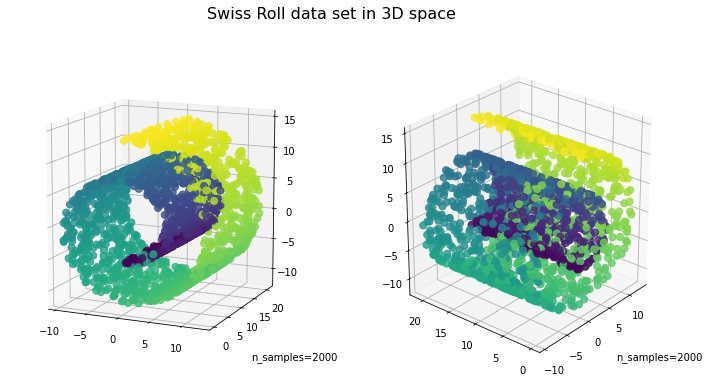

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
fig.add_axes(ax)
ax.scatter(
    sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=50, alpha=0.8
)
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=2000", transform=ax.transAxes)

ax = fig.add_subplot(1, 2, 2, projection='3d')
fig.add_axes(ax)
ax.scatter(
    sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=50, alpha=0.8
)
ax.view_init(azim=-140, elev=25)
_ = ax.text2D(0.8, 0.05, s="n_samples=2000", transform=ax.transAxes)

fig.suptitle('Swiss Roll data set in 3D space', fontsize=16)
plt.show()


#**Dimensionality Reduction techniques**

The objective is to unroll the Swiss Roll dataset and represent it in two dimensions applying dimensionality reduction techniques, and we will observe which returns the best result considering the following aspects:
- How well it maintains the underlying structure of the original manifold.
- How ir preserves the global and local geometry.
- How well it recovers the neighborhood or distance between the data points.


In addition, we will compare certain aspects such as: 
- Speed
- Computational complexity
- Sensitivities to outliers, noise, and parameter settings.

##Linear methods

We use scaled and unscaled data to compare the result.

###PCA

In [ ]:
pca = PCA(n_components=2, svd_solver='auto')
sr_sspca = pca.fit_transform(x_std)
sr_pca = pca.fit_transform(sr_points)
#linear kernel in kpca is the same as standard pca

###MDS

In [ ]:
embedding = MDS(n_components=2, dissimilarity = 'euclidean', metric=True)
sr_ssmds = embedding.fit_transform(x_std)
sr_mds = embedding.fit_transform(sr_points)

## Non-linear methods: **Manifold Learning**

###LLE

In [ ]:
sr_lle, sr_err = manifold.locally_linear_embedding(
    sr_points, n_neighbors=15, n_components=2
)

###ISOMAP

In [ ]:
sr_isomap = manifold.Isomap(n_neighbors = 15, n_components = 2).fit_transform(sr_points)

###Diffusion Map
Using datafold
https://datafold-dev.gitlab.io/datafold/tutorial_03_basic_dmap_scurve.html

In [ ]:
X_pcm = pfold.PCManifold(sr_points)
X_pcm.optimize_parameters()

print(f"epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}")

epsilon=1.5995590436926868, cut-off=5.428164190125861


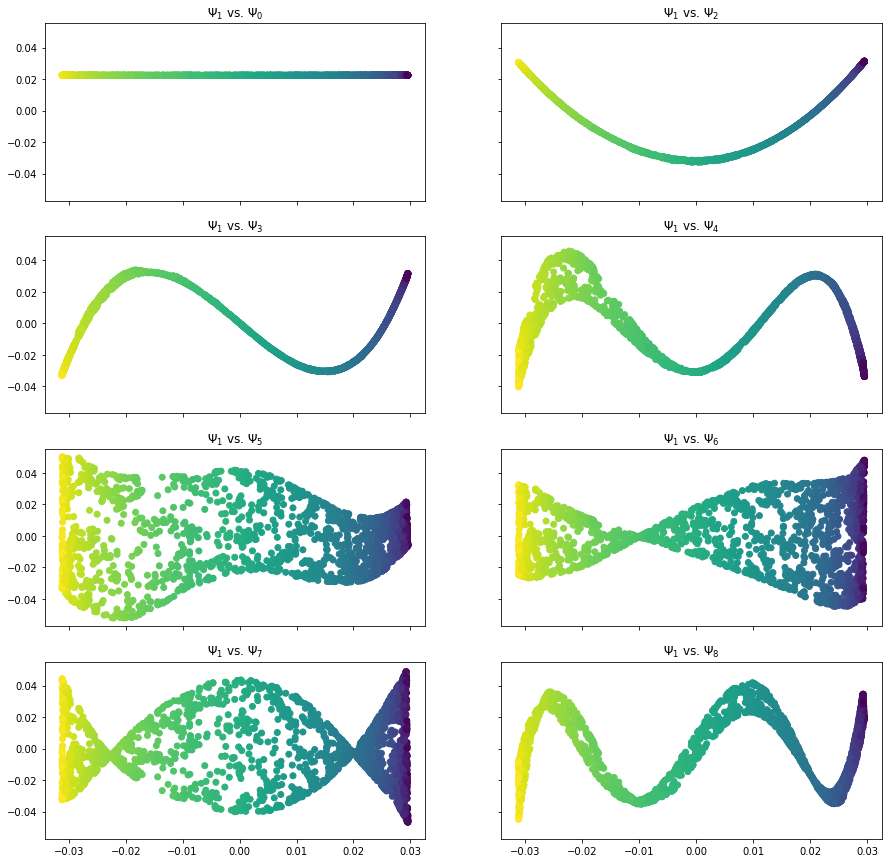

In [ ]:
idx_plot = np.random.permutation(sr_points.shape[0])[0:2000]

dmap1 = dfold.DiffusionMaps(
    kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
    n_eigenpairs=9,
    dist_kwargs=dict(cut_off=X_pcm.cut_off),
)
dmap1 = dmap1.fit(X_pcm)
evecs, evals = dmap1.eigenvectors_, dmap1.eigenvalues_

plot_pairwise_eigenvector(
    eigenvectors=dmap1.eigenvectors_[idx_plot, :],
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict( c=sr_color[idx_plot]),
)

#**Visualization**

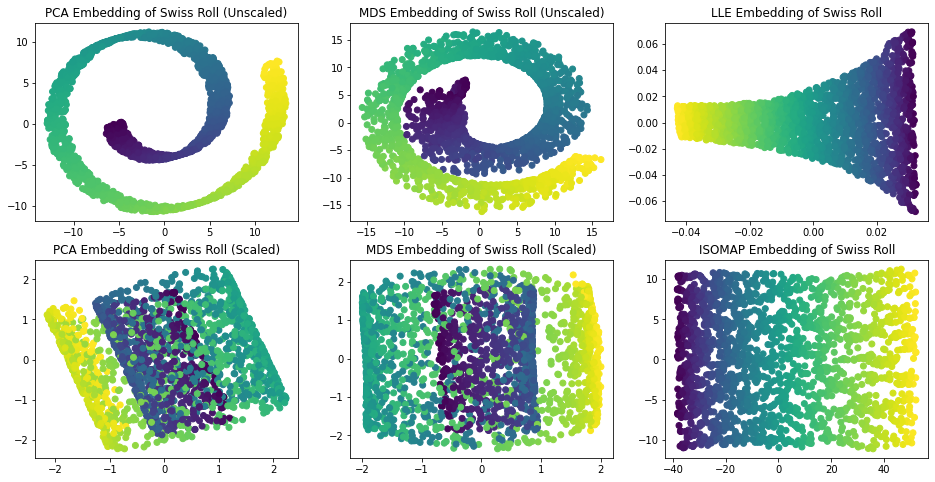

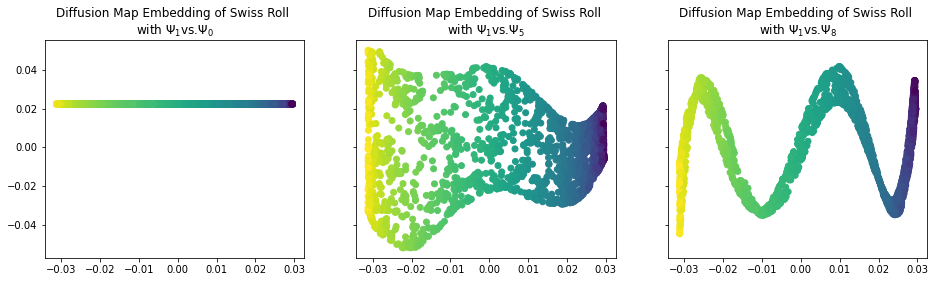

In [ ]:
fig, axs = plt.subplots(figsize=(16,8), ncols = 3, nrows = 2)
axs[0][0].scatter(sr_pca[:, 0], sr_pca[:, 1], c=sr_color)
_ = axs[0][0].set_title("PCA Embedding of Swiss Roll (Unscaled)")
axs[1][0].scatter(sr_sspca[:, 0], sr_sspca[:, 1], c=sr_color)
_ = axs[1][0].set_title("PCA Embedding of Swiss Roll (Scaled)")
axs[0][1].scatter(sr_mds[:, 0], sr_mds[:, 1], c=sr_color)
_ = axs[0][1].set_title("MDS Embedding of Swiss Roll (Unscaled)")
axs[1][1].scatter(sr_ssmds[:, 0], sr_ssmds[:, 1], c=sr_color)
_ = axs[1][1].set_title("MDS Embedding of Swiss Roll (Scaled)")
axs[0][2].scatter(sr_lle[:, 0], sr_lle[:,1], c=sr_color)
axs[0][2].set_title("LLE Embedding of Swiss Roll")
axs[1][2].scatter(sr_isomap[:, 0], sr_isomap[:, 1], c=sr_color)
_ = axs[1][2].set_title("ISOMAP Embedding of Swiss Roll")


dmap1.eigenvectors_ = evecs[:,[0,1,5,8]]
plot_pairwise_eigenvector(
    eigenvectors=dmap1.eigenvectors_[idx_plot, :],
    n=1,
    fig_params=dict(figsize=[15.82, 4],ncols=3, nrows=1),
    scatter_params=dict(c=sr_color[idx_plot]),
)
all_axes = plt.gcf().get_axes()
all_axes[0].set_title("Diffusion Map Embedding of Swiss Roll \nwith " r"$\Psi_{{{}}}$vs.$\Psi_{{{}}}$".format(1, 0))
all_axes[1].set_title("Diffusion Map Embedding of Swiss Roll \nwith " r"$\Psi_{{{}}}$vs.$\Psi_{{{}}}$".format(1, 5))
all_axes[2].set_title("Diffusion Map Embedding of Swiss Roll \nwith " r"$\Psi_{{{}}}$vs.$\Psi_{{{}}}$".format(1, 8))

plt.show()

##Result


We can observe that the linear methods failed to unroll the Swiss Roll dataset using both scaled and unscaled data. While on the other hand, non-linear methods offer different representations of the underlying structure.

- Both linear methods (PCA and cMDS) applied to **scaled** data returns a linear projection of the data set, it fails to unroll it, in addition, the order and distance between the data points do not correspond to the original structure either.
- On the other hand, for **unscaled** data, it is observed that both linear methods manage to flatten the roll, demonstrating at least the shape it has, although it cannot unroll it. This means that, although the order between data points is preserved, the distance between the non-neighboring points does not correspond to the original. Regarding variability, it is observed that cMDS better represents the depth of the data.
- In the cases of non-linear methods, it is observed that **Isomap** returns the unrolled swiss roll that best represents the underlying structure, preserving both the global and local structure while recovering the order and distances between data points.
- Unlike Isomap, **LLE** manages to unroll the Swiss Roll but returns a non-uniform representation, so we conclude that it maintains the local structure (both the order and the distance between neighbors) but loses the global structure since it is a local method.
- And finally, depending on the eigenvectors you select, the diffusion map offers us different representations of the unrolled dataset. Using only the first eigenvector we obtain a one-dimensional embedding, which preserves order but does not represent variation or global structure. Using the first and eighth eigenvectors we obtain the curve that represents the height of the data in the original space. Finally, using the first and fifth eigenvectors, we obtain the closest representation to the isomap result, which shows the greatest data variation, preserving order, and recovering a certain level of global structure.

More details about the analysis can found in the paper: 
https://drive.google.com/file/d/15xvyitTyOhEUbYpTZYMcuDLRjiX9mTfe/view?usp=sharing
